In [1]:
import pandas as pd
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from adjustText import adjust_text

In [2]:
def load_problematic_file(file_path):
    """Handle files with encoding issues by reading as binary and cleaning"""
    try:
        with open(file_path, 'rb') as f:
            content = f.read()
        
        # Try to decode with error handling
        try:
            text = content.decode('utf-8', errors='ignore')
        except:
            text = content.decode('latin-1', errors='ignore')
        
        # Clean the text and parse JSON
        cleaned_text = text.strip()
        return json.loads(cleaned_text)
    except Exception as e:
        print(f"Failed to load {file_path} even with binary reading: {e}")
        return None

In [3]:
# Set up the data directory
OUTPUT_DIR = Path("output/mls-binary-v1")

In [4]:
# Function to load all results into a dataframe
def load_all_results(output_dir):
    """Load all JSON results from the output directory into a pandas DataFrame"""
    all_results = []
    failed_files = []
    
    # Iterate through all experiment directories
    for exp_dir in output_dir.iterdir():
        if exp_dir.is_dir():
            experiment_id = exp_dir.name
            
            # Load all JSON files in this experiment directory
            for json_file in exp_dir.glob("*.json"):
                try:
                    # Try different encodings to handle special characters
                    encodings_to_try = ['utf-8', 'utf-8-sig', 'latin-1', 'cp1252']
                    data = None
                    
                    for encoding in encodings_to_try:
                        try:
                            with open(json_file, 'r', encoding=encoding) as f:
                                data = json.load(f)
                            break
                        except UnicodeDecodeError:
                            continue
                        except json.JSONDecodeError as e:
                            print(f"JSON decode error in {json_file} with {encoding}: {e}")
                            continue
                    
                    if data is not None:
                        # Add experiment_id to the data
                        data['experiment_id'] = experiment_id
                        all_results.append(data)
                    else:
                        # Try the binary reading approach as last resort
                        print(f"Trying binary reading for {json_file}")
                        data = load_problematic_file(json_file)
                        if data is not None:
                            data['experiment_id'] = experiment_id
                            all_results.append(data)
                        else:
                            failed_files.append(str(json_file))
                            print(f"Failed to load {json_file} with any method")
                    
                except Exception as e:
                    failed_files.append(str(json_file))
                    print(f"Error loading {json_file}: {e}")
    
    print(f"\nSuccessfully loaded: {len(all_results)} files")
    print(f"Failed to load: {len(failed_files)} files")
    if failed_files:
        print("Failed files:", failed_files)
    
    return pd.DataFrame(all_results)

# Load all results
print("Loading all results from output/mls-binary-v1...")
df = load_all_results(OUTPUT_DIR)
print(f"Loaded {len(df)} results")
print(f"Columns: {list(df.columns)}")
print(f"Shape: {df.shape}")

Loading all results from output/mls-binary-v1...

Successfully loaded: 4720 files
Failed to load: 0 files
Loaded 4720 results
Columns: ['prompt_id', 'input_image_path', 'user_prompt', 'model_provider', 'model_name', 'input_chars', 'input_tokens', 'output_chars', 'output_tokens', 'ttft_ms', 'total_latency_ms', 'response_text', 'http_status', 'error_category', 'error_message', 'temperature', 'top_p', 'experiment_id']
Shape: (4720, 18)


In [5]:
# Show basic info about the loaded data
if len(df) > 0:
    print(f"\nUnique models: {df['model_name'].nunique()}")
    print(f"Unique experiments: {df['experiment_id'].nunique()}")
    print(f"Model providers: {df['model_provider'].unique()}")
else:
    print("No data loaded successfully!")


Unique models: 10
Unique experiments: 472
Model providers: ['anthropic' 'openai' 'grok']


In [6]:
# Parse the response text to extract the midline shift predictions
def parse_response(response_text):
    """Parse the JSON response to extract midline shift prediction"""
    try:
        # Clean the response text and parse JSON
        # Remove any extra whitespace and parse
        cleaned_response = response_text.strip()
        parsed = json.loads(cleaned_response)
        prediction = int(parsed.get('midline-shift-present', None))

        # Only count valid prediction
        if prediction != 0 and prediction != 1 :
            return None
        else:
            return prediction
    except:
        return None

# Add parsed predictions to the dataframe
df['midline_shift_prediction'] = df['response_text'].apply(parse_response)

print("=== Response Parsing Results ===")
print(f"Successfully parsed responses: {df['midline_shift_prediction'].notna().sum()}")
print(f"Failed to parse: {df['midline_shift_prediction'].isna().sum()}")

=== Response Parsing Results ===
Successfully parsed responses: 3901
Failed to parse: 819


In [7]:
# Create separate dataframes for each model
print("=== Creating separate dataframes for each model ===")

# Get unique models
unique_models = df['model_name'].unique()
print(f"Found {len(unique_models)} unique models: {unique_models}")

# Create a dictionary to store dataframes for each model
model_dataframes = {}

for model in unique_models:
    # Filter data for this specific model
    model_df = df[df['model_name'] == model].copy()
    
    # Add some derived columns
    model_df['latency_seconds'] = model_df['total_latency_ms'] / 1000
    model_df['ttft_seconds'] = model_df['ttft_ms'] / 1000
    model_df['has_error'] = model_df['error_message'].notna()
    
    # Store in dictionary
    model_dataframes[model] = model_df
    
    print(f"Model: {model}")
    print(f"  - Shape: {model_df.shape}")
    print(f"  - Experiments: {model_df['experiment_id'].nunique()}")
    print(f"  - Successful runs: {model_df['midline_shift_prediction'].notna().sum()}")
    print(f"  - Error rate: {model_df['has_error'].mean():.2%}")
    print(f"  - Avg latency: {model_df['total_latency_ms'].mean():.2f} ms")
    print()

print(f"Created {len(model_dataframes)} separate dataframes")

=== Creating separate dataframes for each model ===
Found 10 unique models: ['claude-3-7-sonnet-latest' 'claude-opus-4-1-20250805'
 'claude-opus-4-20250514' 'claude-sonnet-4-20250514' 'gpt-4.1' 'gpt-4o'
 'gpt-5-chat-latest' 'gpt-5' 'grok-4-fast-reasoning' 'o1']
Model: claude-3-7-sonnet-latest
  - Shape: (472, 22)
  - Experiments: 472
  - Successful runs: 470
  - Error rate: 0.00%
  - Avg latency: 1533.92 ms

Model: claude-opus-4-1-20250805
  - Shape: (472, 22)
  - Experiments: 472
  - Successful runs: 401
  - Error rate: 0.64%
  - Avg latency: 5127.08 ms

Model: claude-opus-4-20250514
  - Shape: (472, 22)
  - Experiments: 472
  - Successful runs: 436
  - Error rate: 0.21%
  - Avg latency: 2493.50 ms

Model: claude-sonnet-4-20250514
  - Shape: (472, 22)
  - Experiments: 472
  - Successful runs: 426
  - Error rate: 0.00%
  - Avg latency: 2428.45 ms

Model: gpt-4.1
  - Shape: (472, 22)
  - Experiments: 472
  - Successful runs: 281
  - Error rate: 0.21%
  - Avg latency: 61869.72 ms

Model:

In [28]:
# Save each model's dataframe to separate CSV files
print("=== Saving individual model dataframes ===")

for model_name, model_df in model_dataframes.items():
    filename = f"reports/mls_binary_{model_name}_results.csv"
    
    # Save to CSV
    model_df.to_csv(filename, index=False)
    print(f"Saved {model_name} -> {filename} ({model_df.shape[0]} rows)")

print(f"\nSaved {len(model_dataframes)} individual model dataframes")

=== Saving individual model dataframes ===
Saved claude-3-7-sonnet-latest -> reports/mls_binary_claude-3-7-sonnet-latest_results.csv (472 rows)
Saved claude-opus-4-1-20250805 -> reports/mls_binary_claude-opus-4-1-20250805_results.csv (472 rows)
Saved claude-opus-4-20250514 -> reports/mls_binary_claude-opus-4-20250514_results.csv (472 rows)
Saved claude-sonnet-4-20250514 -> reports/mls_binary_claude-sonnet-4-20250514_results.csv (472 rows)
Saved gpt-4.1 -> reports/mls_binary_gpt-4.1_results.csv (472 rows)
Saved gpt-4o -> reports/mls_binary_gpt-4o_results.csv (472 rows)
Saved gpt-5-chat-latest -> reports/mls_binary_gpt-5-chat-latest_results.csv (472 rows)
Saved gpt-5 -> reports/mls_binary_gpt-5_results.csv (472 rows)
Saved grok-4-fast-reasoning -> reports/mls_binary_grok-4-fast-reasoning_results.csv (472 rows)
Saved o1 -> reports/mls_binary_o1_results.csv (472 rows)

Saved 10 individual model dataframes


# Task Completion Analysis

In [8]:
# Calculate success rate (successful runs / total experiments) for each model
print("=== Model Success Rate Analysis ===")

success_rates = {}
for model_name, model_df in model_dataframes.items():
    total_experiments = len(model_df)
    successful_runs = model_df['midline_shift_prediction'].notna().sum()
    success_rate = successful_runs / total_experiments if total_experiments > 0 else 0
    fail_rate = 1 - success_rate
    
    success_rates[model_name] = {
        'total_experiments': total_experiments,
        'successful_runs': successful_runs,
        'failed_runs': total_experiments - successful_runs,
        'success_rate': success_rate,
        'fail_rate': fail_rate
    }
    
    print(f"{model_name}:")
    print(f"  Total experiments: {total_experiments}")
    print(f"  Successful runs: {successful_runs}")
    print(f"  Failed runs: {total_experiments - successful_runs}")
    print(f"  Success rate: {success_rate:.2%}")
    print(f"  Fail rate: {fail_rate:.2%}")
    print()

# Convert to DataFrame
success_df = pd.DataFrame(success_rates).T
print("Success rate summary:")
print(success_df[['total_experiments', 'successful_runs', 'failed_runs', 'success_rate', 'fail_rate']])

=== Model Success Rate Analysis ===
claude-3-7-sonnet-latest:
  Total experiments: 472
  Successful runs: 470
  Failed runs: 2
  Success rate: 99.58%
  Fail rate: 0.42%

claude-opus-4-1-20250805:
  Total experiments: 472
  Successful runs: 401
  Failed runs: 71
  Success rate: 84.96%
  Fail rate: 15.04%

claude-opus-4-20250514:
  Total experiments: 472
  Successful runs: 436
  Failed runs: 36
  Success rate: 92.37%
  Fail rate: 7.63%

claude-sonnet-4-20250514:
  Total experiments: 472
  Successful runs: 426
  Failed runs: 46
  Success rate: 90.25%
  Fail rate: 9.75%

gpt-4.1:
  Total experiments: 472
  Successful runs: 281
  Failed runs: 191
  Success rate: 59.53%
  Fail rate: 40.47%

gpt-4o:
  Total experiments: 472
  Successful runs: 71
  Failed runs: 401
  Success rate: 15.04%
  Fail rate: 84.96%

gpt-5-chat-latest:
  Total experiments: 472
  Successful runs: 472
  Failed runs: 0
  Success rate: 100.00%
  Fail rate: 0.00%

gpt-5:
  Total experiments: 472
  Successful runs: 467
  Fai

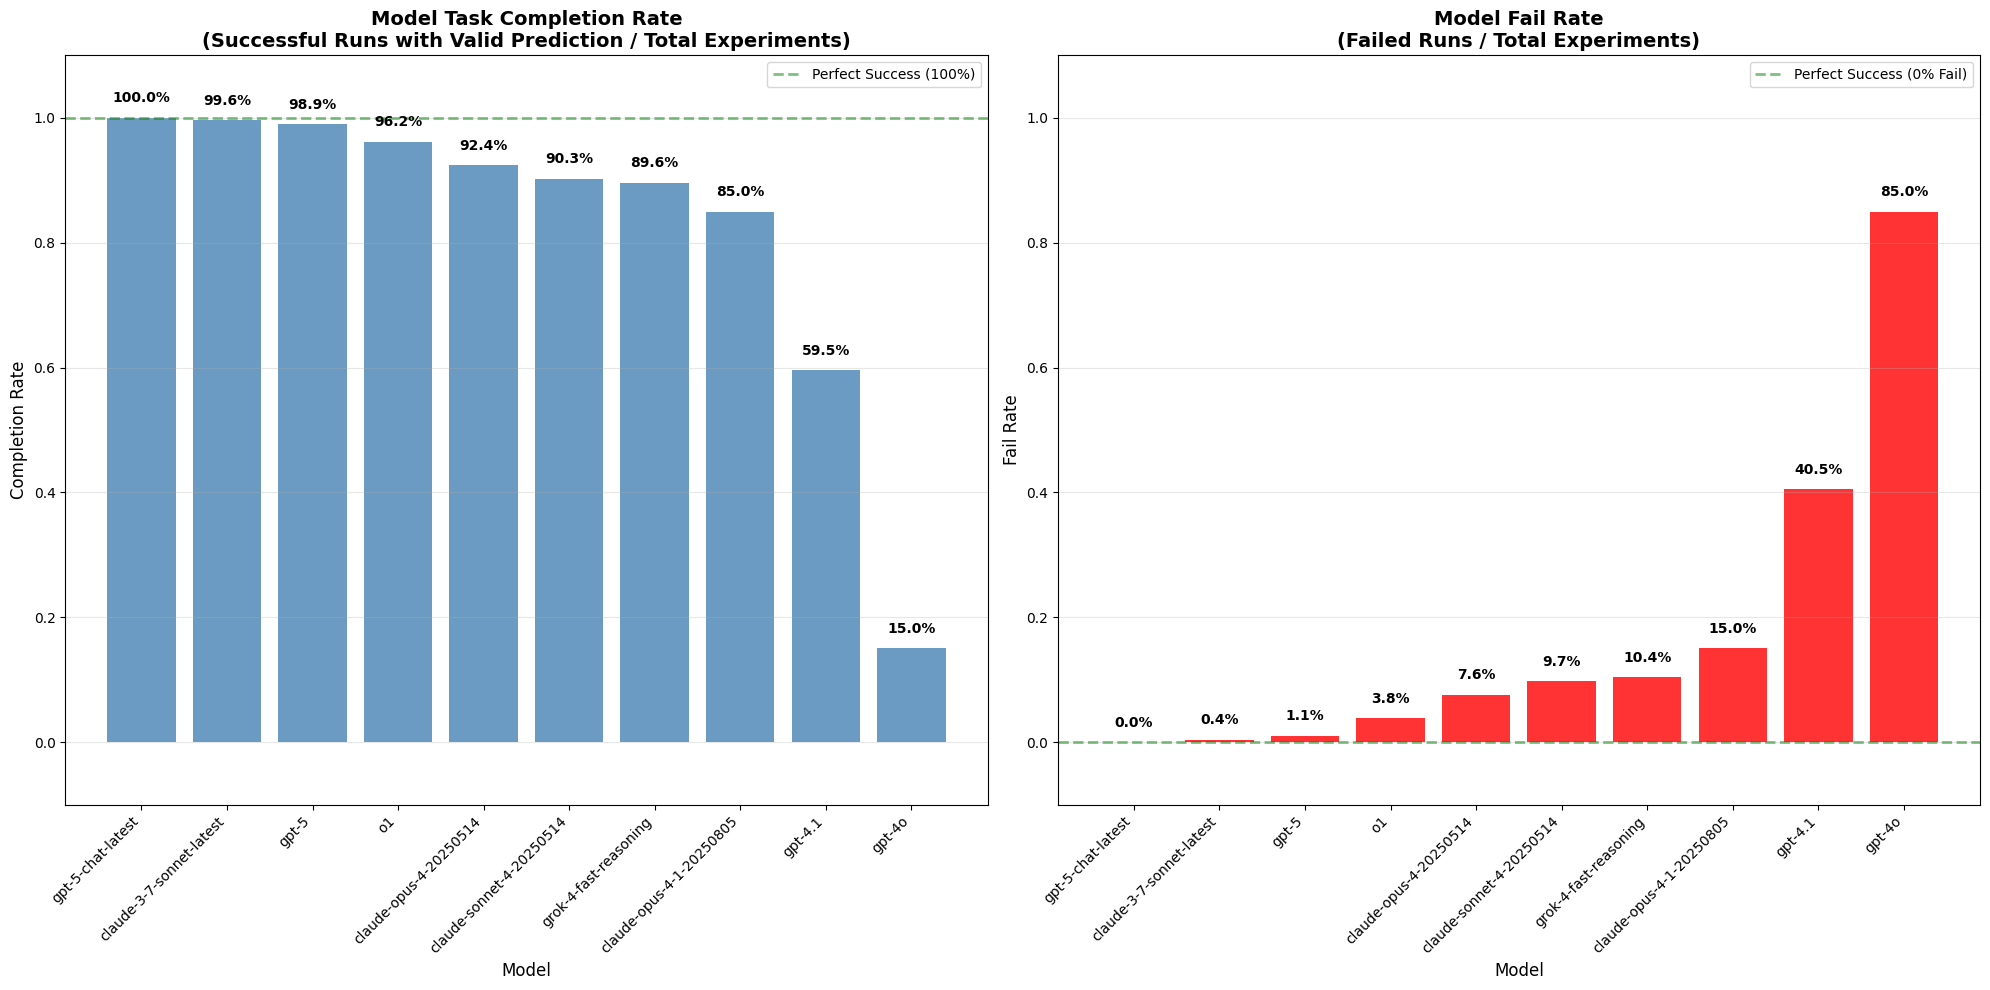

Saved success/fail rate plots to: reports/plots/model_success_fail_rates.png


In [31]:
# Create success rate visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Completion Rate (Successful runs / Total experiments)
success_data = success_df['success_rate'].sort_values(ascending=False)
bars1 = ax1.bar(range(len(success_data)), success_data.values, color='steelblue', alpha=0.8)
ax1.set_title('Model Task Completion Rate\n(Successful Runs with Valid Prediction / Total Experiments)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Completion Rate', fontsize=12)
ax1.set_xticks(range(len(success_data)))
ax1.set_xticklabels(success_data.index, rotation=45, ha='right')
ax1.set_ylim([-0.1, 1.1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars1, success_data.values)):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
             f'{value:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add horizontal line at 100% success rate
ax1.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Perfect Success (100%)')
ax1.legend()

# Plot 2: Fail Rate (Failed runs / Total experiments)
fail_data = success_df['fail_rate'].sort_values(ascending=True)
bars2 = ax2.bar(range(len(fail_data)), fail_data.values, color='red', alpha=0.8)
ax2.set_title('Model Fail Rate\n(Failed Runs / Total Experiments)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Fail Rate', fontsize=12)
ax2.set_xticks(range(len(fail_data)))
ax2.set_xticklabels(fail_data.index, rotation=45, ha='right')
ax2.set_ylim([-0.1, 1.1])
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars2, fail_data.values)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
             f'{value:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add horizontal line at 0% fail rate
ax2.axhline(y=0.0, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Perfect Success (0% Fail)')
ax2.legend()

plt.tight_layout()
plt.savefig('reports/plots/model_success_fail_rates.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved success/fail rate plots to: reports/plots/model_success_fail_rates.png")

C:\Users\nguyetpvt\AppData\Local\Temp\ipykernel_16020\804342789.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right')


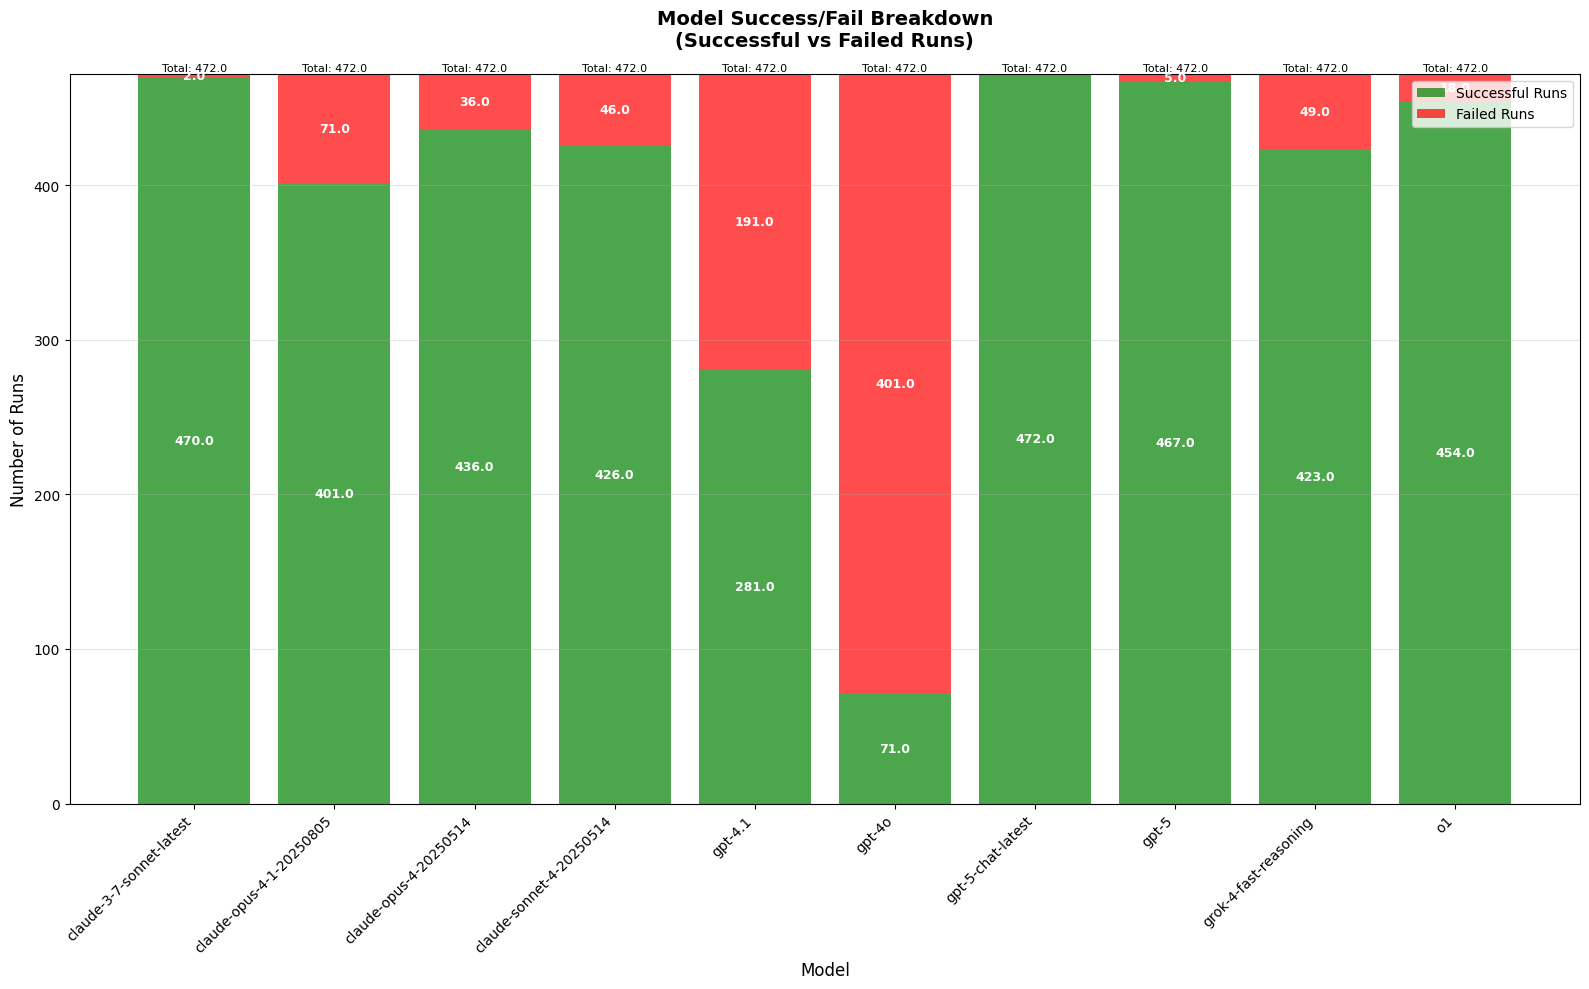

Saved success/fail breakdown plot to: reports/plots/model_success_fail_breakdown.png
Saved success rate data to: reports/csv_reports/model_success_rates.csv


In [36]:
# Create a detailed success/fail breakdown plot
fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data for stacked bar chart
models = success_df.index
successful_runs = success_df['successful_runs'].values
failed_runs = success_df['failed_runs'].values
total_experiments = success_df['total_experiments'].values

# Create stacked bar chart
bars_success = ax.bar(models, successful_runs, color='green', alpha=0.7, label='Successful Runs')
bars_fail = ax.bar(models, failed_runs, bottom=successful_runs, color='red', alpha=0.7, label='Failed Runs')

# Add value labels on bars
for i, (model, success, fail, total) in enumerate(zip(models, successful_runs, failed_runs, total_experiments)):
    # Label for successful runs
    if success > 0:
        ax.text(i, success/2, f'{success}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    # Label for failed runs
    if fail > 0:
        ax.text(i, success + fail/2, f'{fail}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    # Total label at the top
    ax.text(i, total + 0.5, f'Total: {total}', ha='center', va='bottom', fontsize=8, color='black')

ax.set_title('Model Success/Fail Breakdown\n(Successful vs Failed Runs)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Number of Runs', fontsize=12)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('reports/plots/model_success_fail_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved success/fail breakdown plot to: reports/plots/model_success_fail_breakdown.png")

# Save success rate data to CSV
success_df.to_csv('reports/csv_reports/model_success_rates.csv')
print("Saved success rate data to: reports/csv_reports/model_success_rates.csv")

Invalid responses available for text analysis: 813


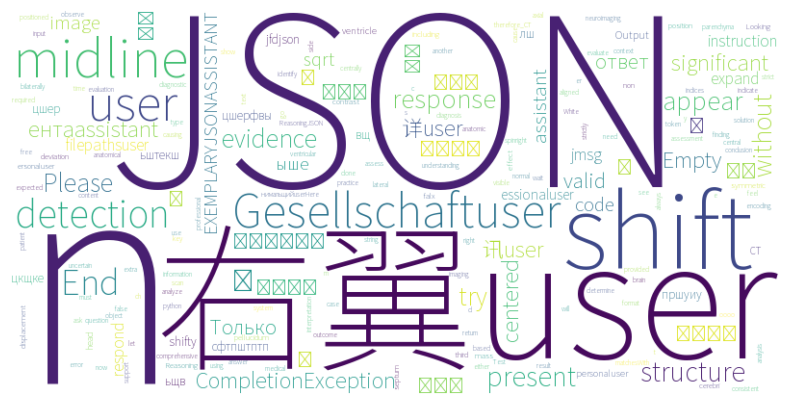

Saved plot to: reports/plots/invalid_response_word_cloud.png


In [9]:
# Visualize invalid response_text content 
from wordcloud import WordCloud
from matplotlib import ft2font
from pathlib import Path

# Select invalid responses (failed to parse)
invalid_df = df[df['midline_shift_prediction'].isna() & df['response_text'].notna()].copy()
print(f"Invalid responses available for text analysis: {len(invalid_df)}")

texts = "\n".join(invalid_df['response_text'].astype(str).tolist())

# Resolve primary CJK font and fallback regular font
primary_font_path = Path("C://Users//nguyetpvt//AppData//Local//Microsoft//Windows//Fonts//NotoSansCJK-VF.ttf.ttc")
fallback_font_path = Path("C://Users//nguyetpvt//AppData//Local//Microsoft//Windows//Fonts//NotoSans-VariableFont_wdth,wght.ttf")


# Helper: determine if a word is fully supported by a font (all glyphs available)
def word_supported_by_font(word, font_path: Path) -> bool:
    try:
        ft = ft2font.FT2Font(str(font_path))
        for ch in word:
            # Skip whitespace/newlines
            if ch.isspace():
                continue
            if ft.get_char_index(ord(ch)) == 0:
                return False
        return True
    except Exception:
        # If we can't validate, assume unsupported to be safe
        return False


# Generate two word clouds and composite so that unsupported words render with fallback font
wc_kwargs = dict(width=800, height=400, background_color='white', collocations=False, random_state=42)

wc = WordCloud(font_path=str(primary_font_path) if primary_font_path else None, **wc_kwargs).generate(texts)

# Display the generated image using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()
plt.imsave('reports/plots/invalid_response_word_cloud.png', wc)
plt.show()

print("Saved plot to: reports/plots/invalid_response_word_cloud.png")

# Accuracy Analysis

In [10]:
# Load ground truth data
print("=== Loading Ground Truth Data ===")
ground_truth_df = pd.read_csv('../eda/ground_truth.csv')
print(f"Ground truth shape: {ground_truth_df.shape}")
print(f"Ground truth columns: {list(ground_truth_df.columns)}")
print(f"Ground truth distribution: {ground_truth_df['ground_truth'].value_counts()}")

=== Loading Ground Truth Data ===
Ground truth shape: (472, 2)
Ground truth columns: ['name', 'ground_truth']
Ground truth distribution: ground_truth
0    416
1     56
Name: count, dtype: int64


In [11]:
# Create mapping from experiment_id to ground truth
print("=== Creating Experiment ID to Ground Truth Mapping ===")

# Extract experiment ID from the name format "CQ500-CT-{experiment_id}"
ground_truth_df['experiment_id'] = ground_truth_df['name'].str.extract(r'CQ500-CT-(\d+)').astype(int)

# Create mapping dictionary
experiment_to_ground_truth = dict(zip(ground_truth_df['experiment_id'], ground_truth_df['ground_truth']))

print(f"Created mapping for {len(experiment_to_ground_truth)} experiments")
print(f"Sample mappings: {dict(list(experiment_to_ground_truth.items())[:10])}")

# Add ground truth to the main dataframe
df['ground_truth'] = df['experiment_id'].astype(int).map(experiment_to_ground_truth)

print(f"\nDataframe with ground truth shape: {df.shape}")
print(f"Ground truth distribution in data: {df['ground_truth'].value_counts()}")
print(f"Missing ground truth values: {df['ground_truth'].isna().sum()}")

=== Creating Experiment ID to Ground Truth Mapping ===
Created mapping for 472 experiments
Sample mappings: {427: 0, 181: 1, 99: 0, 47: 0, 195: 0, 357: 0, 80: 0, 2: 0, 361: 0, 401: 0}

Dataframe with ground truth shape: (4720, 20)
Ground truth distribution in data: ground_truth
0    4160
1     560
Name: count, dtype: int64
Missing ground truth values: 0


In [12]:
# Accuracy Metrics Calculation
print("=== Calculating Metrics by Model (Accuracy, TPR, FPR, TNR, FNR, Confusion Matrix) ===")

# Store metrics for each model
model_metrics = {}

for model_name, model_df in model_dataframes.items():
    # Add ground truth to model dataframe
    model_df['ground_truth'] = model_df['experiment_id'].astype(int).map(experiment_to_ground_truth)
    
    # Include all data where ground truth is available (treat NaN predictions as wrong)
    valid_data = model_df[model_df['ground_truth'].notna()].copy()
    valid_data_without_na = model_df[model_df['ground_truth'].notna() & model_df['midline_shift_prediction'].notna()].copy()
    
    if len(valid_data) > 0:
        y_true = valid_data['ground_truth'].astype(int)
        # For NaN predictions, treat them as wrong predictions (use opposite of ground truth)
        y_pred = valid_data['midline_shift_prediction'].fillna(1 - valid_data['ground_truth']).astype(int)

        y_true_without_na = valid_data_without_na['ground_truth'].astype(int)
        y_pred_without_na = valid_data_without_na['midline_shift_prediction'].astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true_without_na, y_pred_without_na).ravel()
        
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Sensitivity/Recall)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate (Specificity)
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
        
        model_metrics[model_name] = {
            'accuracy': accuracy,
            'tpr': tpr,  # True Positive Rate
            'fpr': fpr,  # False Positive Rate
            'tnr': tnr,  # True Negative Rate
            'fnr': fnr,  # False Negative Rate
            'true_positives': tp,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'total_samples': len(valid_data)
        }
        
        print(f"\n{model_name}:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  TPR:       {tpr:.4f} (True Positive Rate)")
        print(f"  FPR:       {fpr:.4f} (False Positive Rate)")
        print(f"  TNR:       {tnr:.4f} (True Negative Rate)")
        print(f"  FNR:       {fnr:.4f} (False Negative Rate)")
        print(f"  Samples:   {len(valid_data)}")
    else:
        print(f"\n{model_name}: No valid data for evaluation")

# Convert to DataFrame for easy viewing
metrics_df = pd.DataFrame(model_metrics).T
print("\n=== Updated Metrics Summary DataFrame ===")
print(metrics_df)

=== Calculating Metrics by Model (Accuracy, TPR, FPR, TNR, FNR, Confusion Matrix) ===

claude-3-7-sonnet-latest:
  Accuracy:  0.8729
  TPR:       0.7679 (True Positive Rate)
  FPR:       0.1087 (False Positive Rate)
  TNR:       0.8913 (True Negative Rate)
  FNR:       0.2321 (False Negative Rate)
  Samples:   472

claude-opus-4-1-20250805:
  Accuracy:  0.7818
  TPR:       0.4902 (True Positive Rate)
  FPR:       0.0171 (False Positive Rate)
  TNR:       0.9829 (True Negative Rate)
  FNR:       0.5098 (False Negative Rate)
  Samples:   472

claude-opus-4-20250514:
  Accuracy:  0.8432
  TPR:       0.4038 (True Positive Rate)
  FPR:       0.0182 (False Positive Rate)
  TNR:       0.9818 (True Negative Rate)
  FNR:       0.5962 (False Negative Rate)
  Samples:   472

claude-sonnet-4-20250514:
  Accuracy:  0.8136
  TPR:       0.2449 (True Positive Rate)
  FPR:       0.0133 (False Positive Rate)
  TNR:       0.9867 (True Negative Rate)
  FNR:       0.7551 (False Negative Rate)
  Samples:   

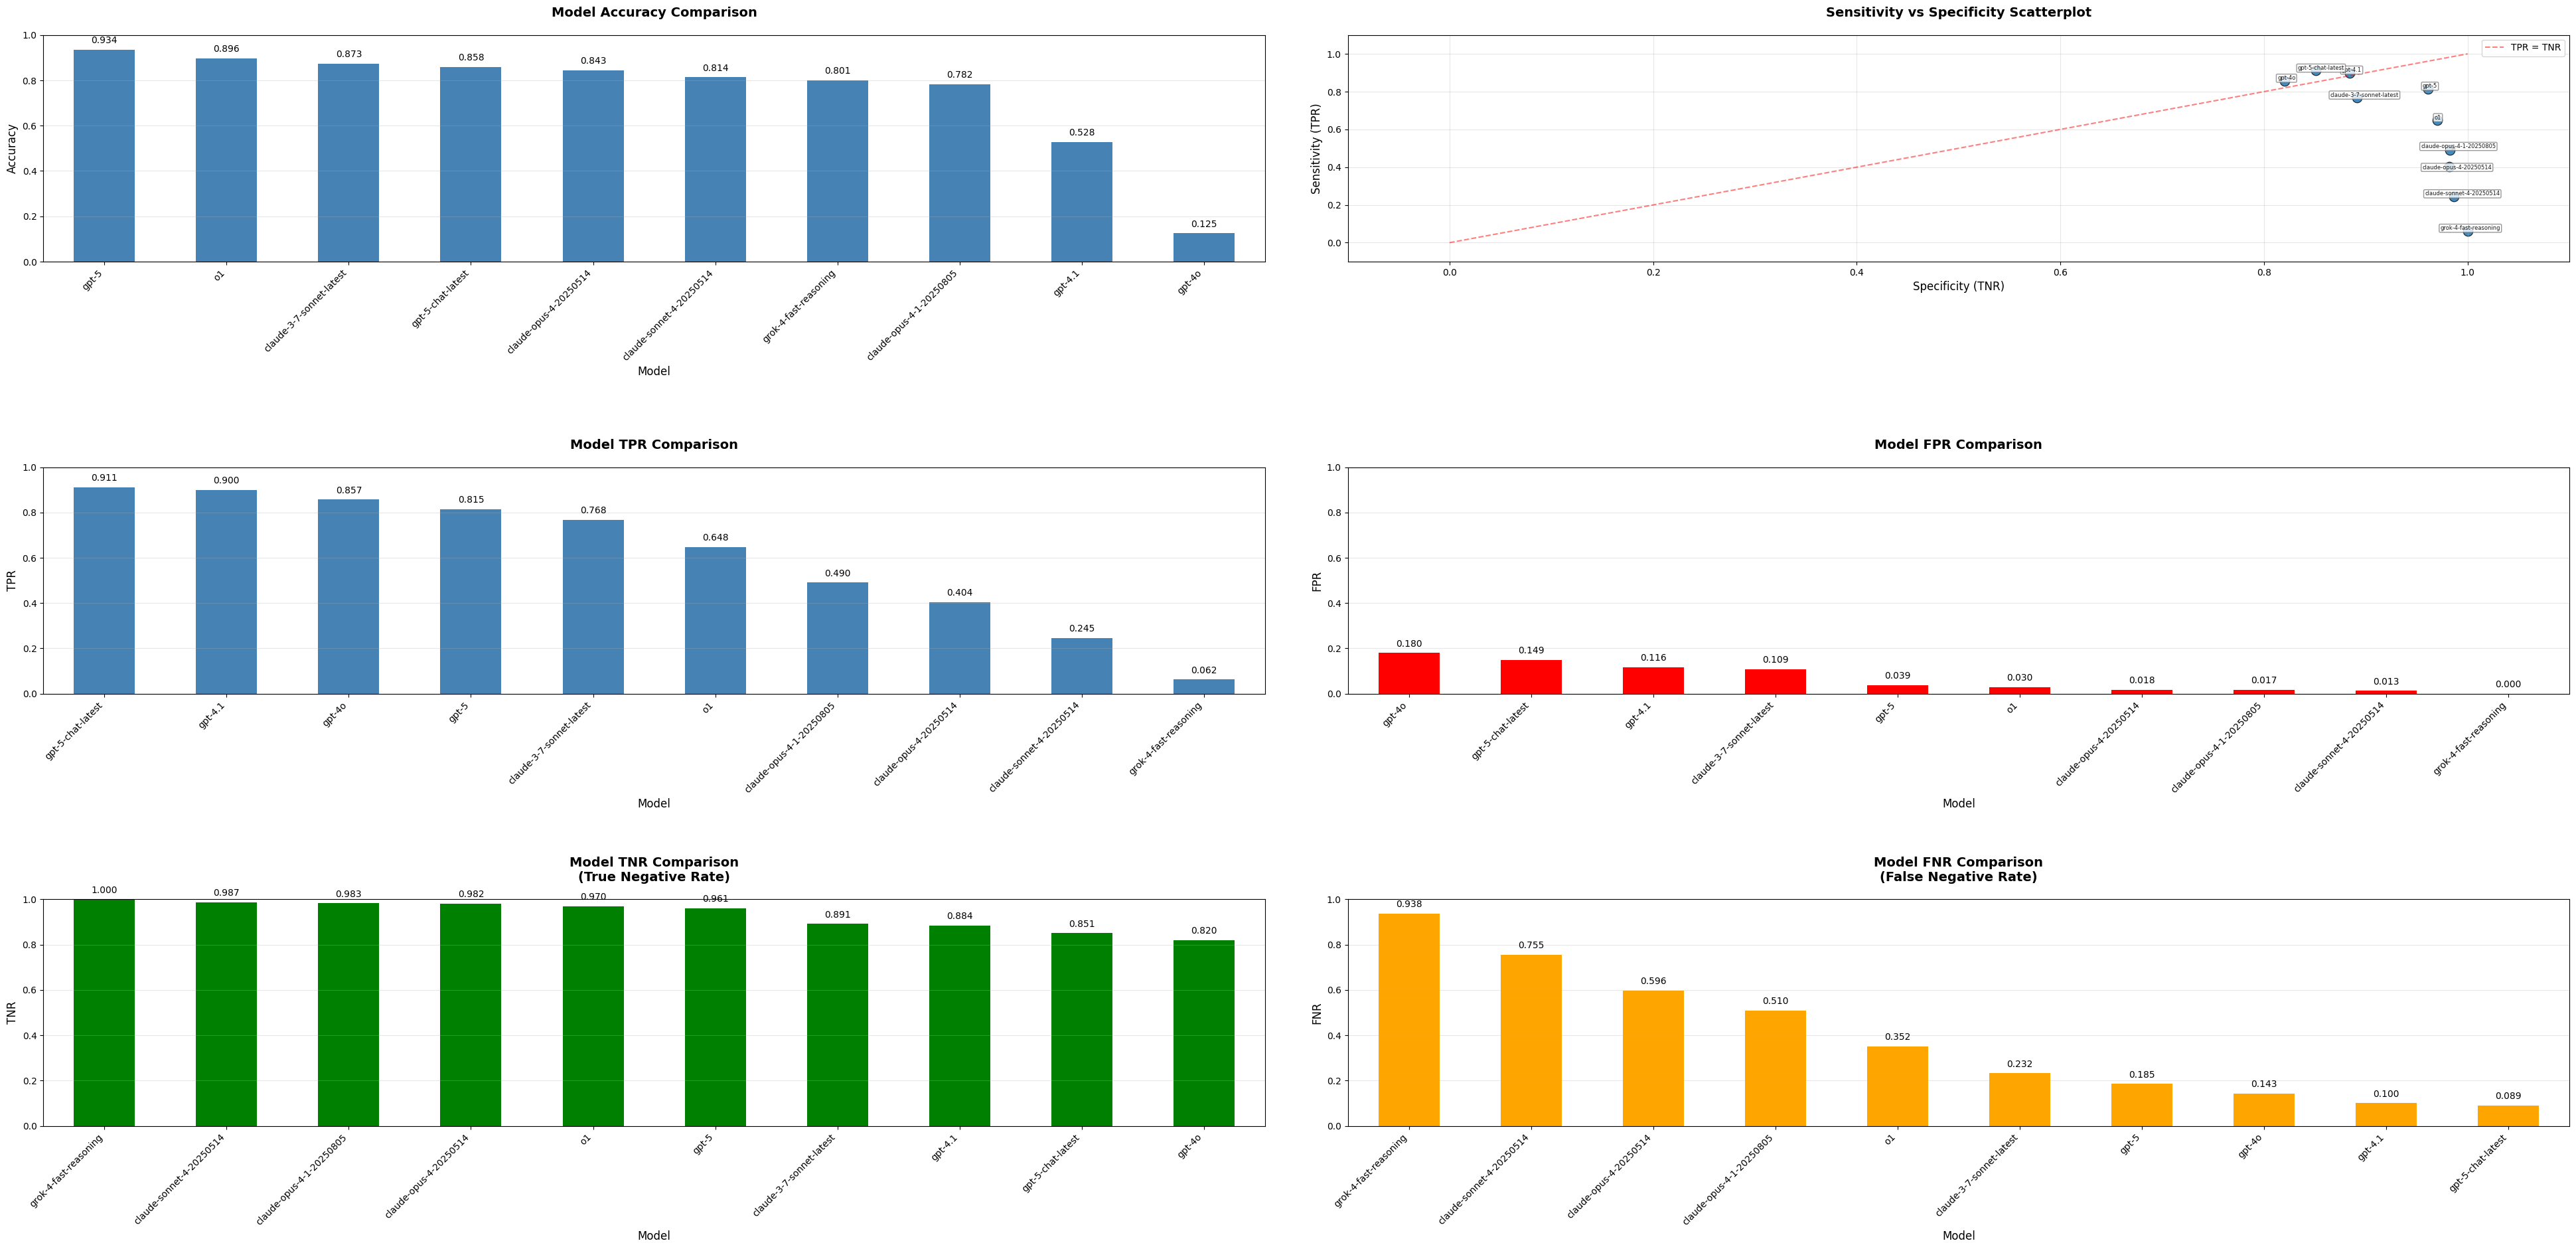

Saved updated metrics plots to: reports/plots/model_accuracy_metrics.png


In [43]:
# Create comparison plots for model metrics
fig, axes = plt.subplots(3, 2, figsize=(40, 20))

# 1. Accuracy comparison
ax1 = axes[0, 0]
accuracy_data = metrics_df['accuracy'].sort_values(ascending=False)
accuracy_data.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(accuracy_data.index, rotation=45, ha='right')
for i, v in enumerate(accuracy_data):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# 2. Scatterplot of TPR vs TNR
ax2 = axes[0, 1]
# De-overlap identical points by applying small circular jitter per (TNR, TPR) group
from collections import defaultdict
coords = list(zip(metrics_df['tnr'].values, metrics_df['tpr'].values))
coord_to_indices = defaultdict(list)
for idx, (x, y) in enumerate(coords):
    coord_to_indices[(x, y)].append(idx)

x_vals = metrics_df['tnr'].values.astype(float)
y_vals = metrics_df['tpr'].values.astype(float)
x_jit = x_vals.copy()
y_jit = y_vals.copy()

radius = 0.02  # small jitter radius
for (x, y), idxs in coord_to_indices.items():
    n = len(idxs)
    if n > 1:
        angles = np.linspace(0, 2*np.pi, n, endpoint=False)
        for k, i in enumerate(idxs):
            x_jit[i] = x + radius * np.cos(angles[k])
            y_jit[i] = y + radius * np.sin(angles[k])

# Keep jittered points within plot bounds
x_jit = np.clip(x_jit, -0.1, 1.1)
y_jit = np.clip(y_jit, -0.1, 1.1)

# Color points by accuracy to encode overall performance
scatter = ax2.scatter(x_jit, y_jit,
                     s=110, alpha=0.85,
                     edgecolors='black', linewidth=0.8)

# Add model labels with overlap avoidance at jittered positions
texts = []
for i, model in enumerate(metrics_df.index):
    texts.append(
        ax2.text(
            x_jit[i],
            y_jit[i],
            model,
            fontsize=6,
            alpha=0.9,
            bbox=dict(boxstyle='round, pad=0.2', facecolor='white', alpha=0.8, edgecolor='gray'),
            ha='left',
            va='bottom'
        )
    )

# Try adjustText for automatic de-overlap; fallback to slight offsets
try:
    adjust_text(
        texts,
        ax=ax2,
        expand_text=(1.05, 1.2),
        expand_points=(1.05, 1.2),
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.6),
        only_move={'points': 'y', 'text': 'xy'}
    )
except Exception:
    for t in texts:
        x, y = t.get_position()
        t.set_position((x + 0.01, y + 0.01))

ax2.set_xlabel('Specificity (TNR)', fontsize=12)
ax2.set_ylabel('Sensitivity (TPR)', fontsize=12)
ax2.set_title('Sensitivity vs Specificity Scatterplot', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlim([-0.1, 1.1])
ax2.set_ylim([-0.1, 1.1])
ax2.grid(True, alpha=0.3)

# Add diagonal line for reference (TPR = TNR)
ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='TPR = TNR')
ax2.legend()

# 3. TPR (True Positive Rate) comparison
ax3 = axes[1, 0]
tpr_data = metrics_df['tpr'].sort_values(ascending=False)
tpr_data.plot(kind='bar', ax=ax3, color='steelblue')
ax3.set_title('Model TPR Comparison', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('Model', fontsize=12)
ax3.set_ylabel('TPR', fontsize=12)
ax3.set_ylim([0, 1.0])
ax3.grid(axis='y', alpha=0.3)
ax3.set_xticklabels(tpr_data.index, rotation=45, ha='right')
for i, v in enumerate(tpr_data):
    ax3.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# 4. FPR (False Positive Rate) comparison
ax4 = axes[1, 1]
fpr_data = metrics_df['fpr'].sort_values(ascending=False)
fpr_data.plot(kind='bar', ax=ax4, color='red')
ax4.set_title('Model FPR Comparison', fontsize=14, fontweight='bold', pad=20)
ax4.set_xlabel('Model', fontsize=12)
ax4.set_ylabel('FPR', fontsize=12)
ax4.set_ylim([0, 1.0])
ax4.grid(axis='y', alpha=0.3)
ax4.set_xticklabels(fpr_data.index, rotation=45, ha='right')
for i, v in enumerate(fpr_data):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# 5. TNR (True Negative Rate) comparison
ax5 = axes[2, 0]
tnr_data = metrics_df['tnr'].sort_values(ascending=False)
tnr_data.plot(kind='bar', ax=ax5, color='green')
ax5.set_title('Model TNR Comparison\n(True Negative Rate)', fontsize=14, fontweight='bold', pad=20)
ax5.set_xlabel('Model', fontsize=12)
ax5.set_ylabel('TNR', fontsize=12)
ax5.set_ylim([0, 1.0])
ax5.grid(axis='y', alpha=0.3)
ax5.set_xticklabels(tnr_data.index, rotation=45, ha='right')
for i, v in enumerate(tnr_data):
    ax5.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# 6. FNR (False Negative Rate) comparison
ax6 = axes[2, 1]
fnr_data = metrics_df['fnr'].sort_values(ascending=False)
fnr_data.plot(kind='bar', ax=ax6, color='orange')
ax6.set_title('Model FNR Comparison\n(False Negative Rate)', fontsize=14, fontweight='bold', pad=20)
ax6.set_xlabel('Model', fontsize=12)
ax6.set_ylabel('FNR', fontsize=12)
ax6.set_ylim([0, 1.0])
ax6.grid(axis='y', alpha=0.3)
ax6.set_xticklabels(fnr_data.index, rotation=45, ha='right')
for i, v in enumerate(fnr_data):
    ax6.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout(pad=5.0)
plt.savefig('reports/plots/model_accuracy_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved updated metrics plots to: reports/plots/model_accuracy_metrics.png")

=== Creating Confusion Matrix Plots (matplotlib) ===


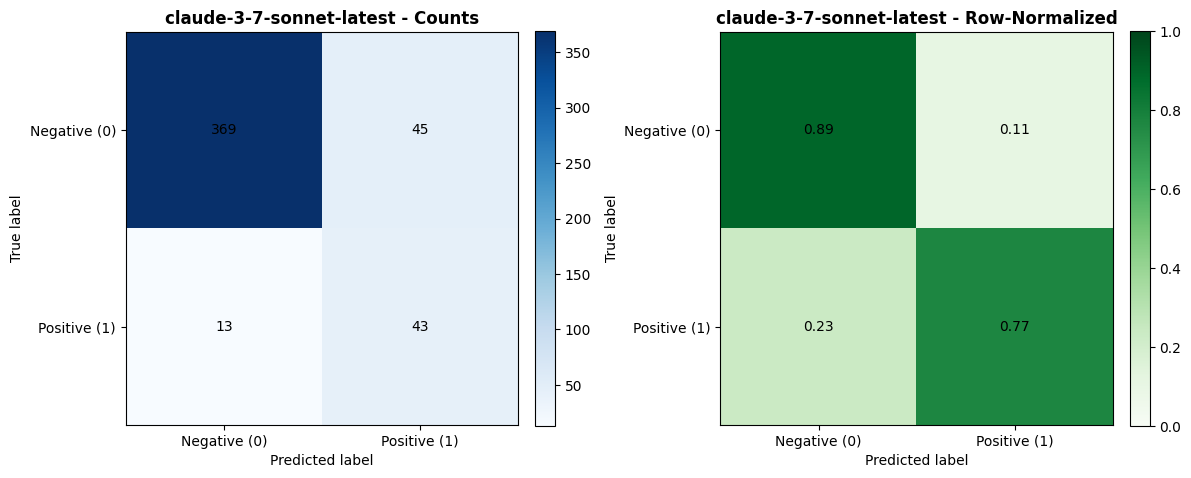

Saved confusion matrix plots to: reports/plots/confusion_matrix_claude-3-7-sonnet-latest.png


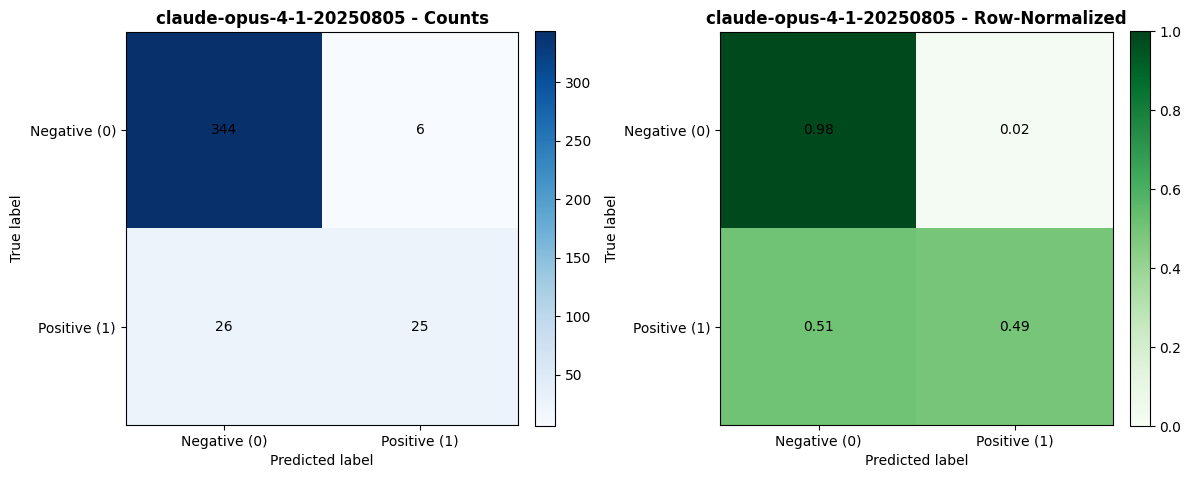

Saved confusion matrix plots to: reports/plots/confusion_matrix_claude-opus-4-1-20250805.png


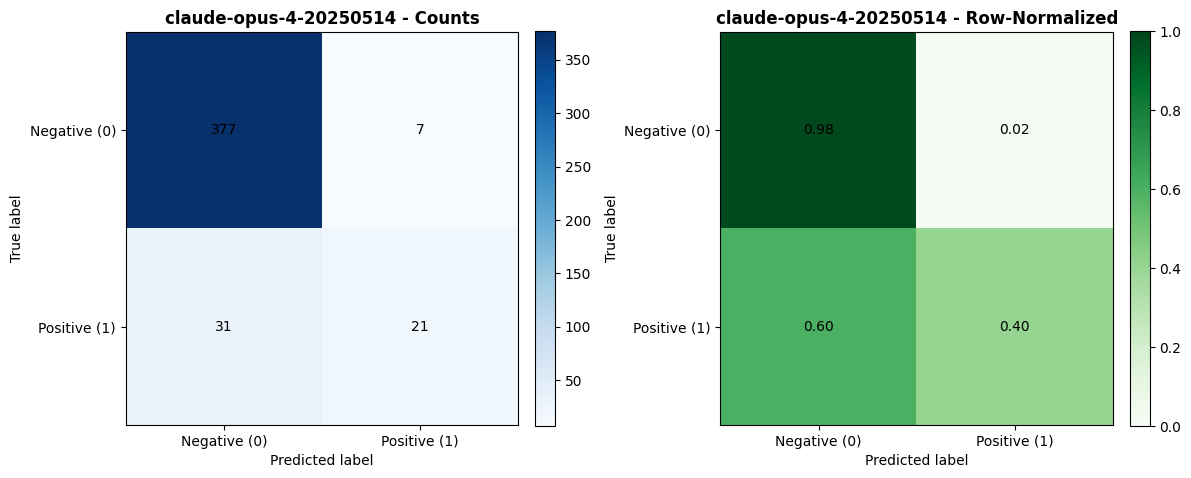

Saved confusion matrix plots to: reports/plots/confusion_matrix_claude-opus-4-20250514.png


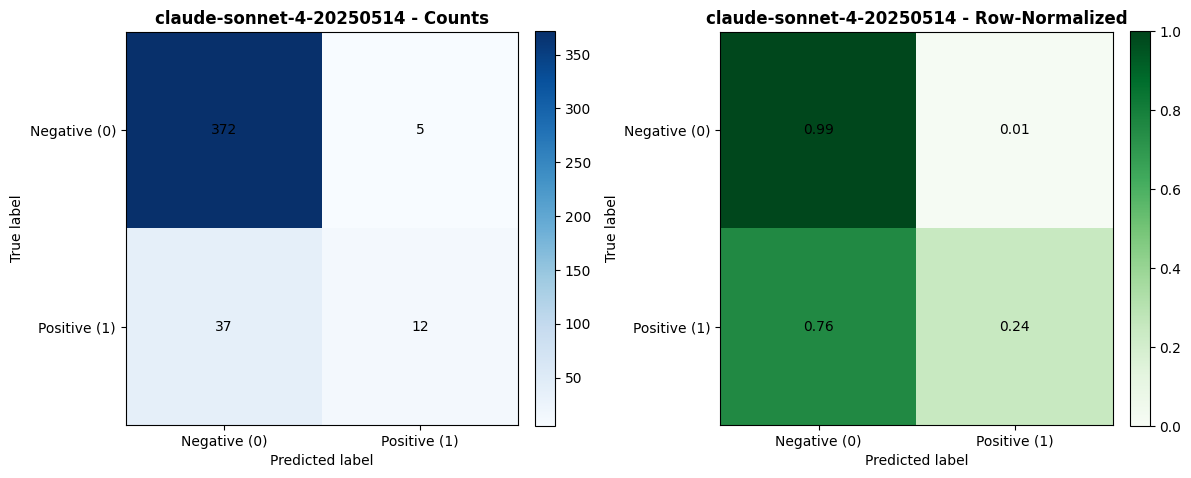

Saved confusion matrix plots to: reports/plots/confusion_matrix_claude-sonnet-4-20250514.png


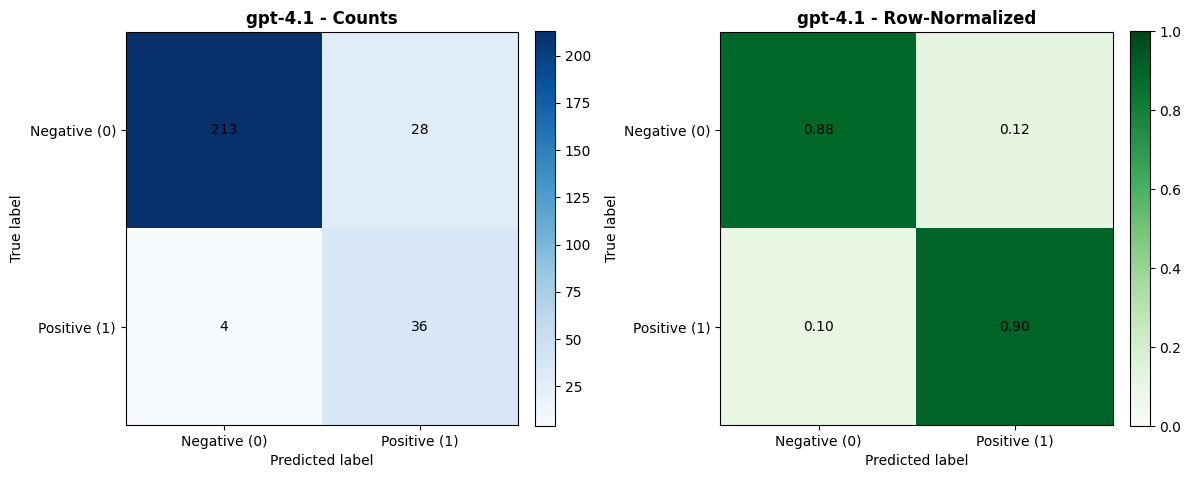

Saved confusion matrix plots to: reports/plots/confusion_matrix_gpt-4.1.png


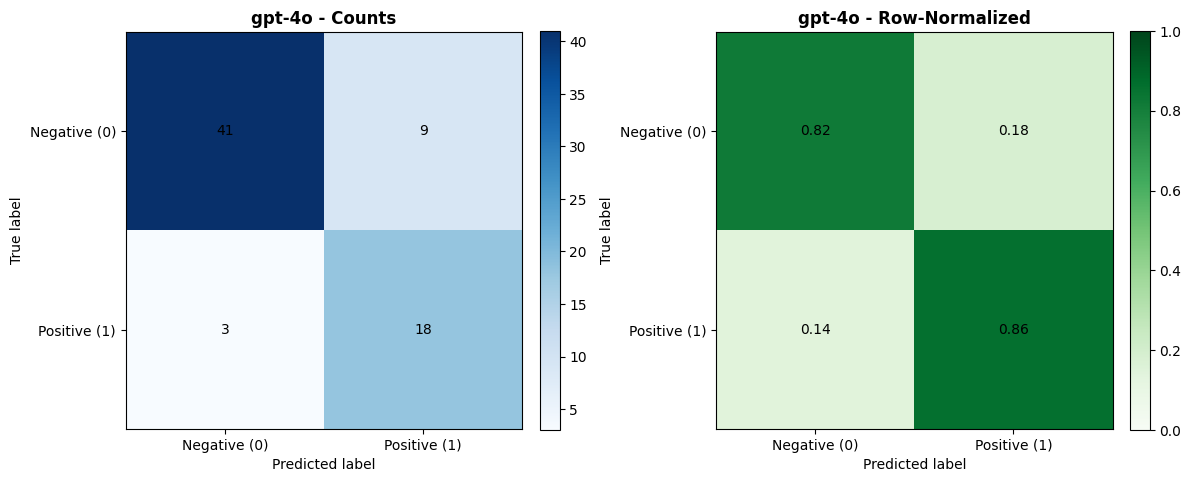

Saved confusion matrix plots to: reports/plots/confusion_matrix_gpt-4o.png


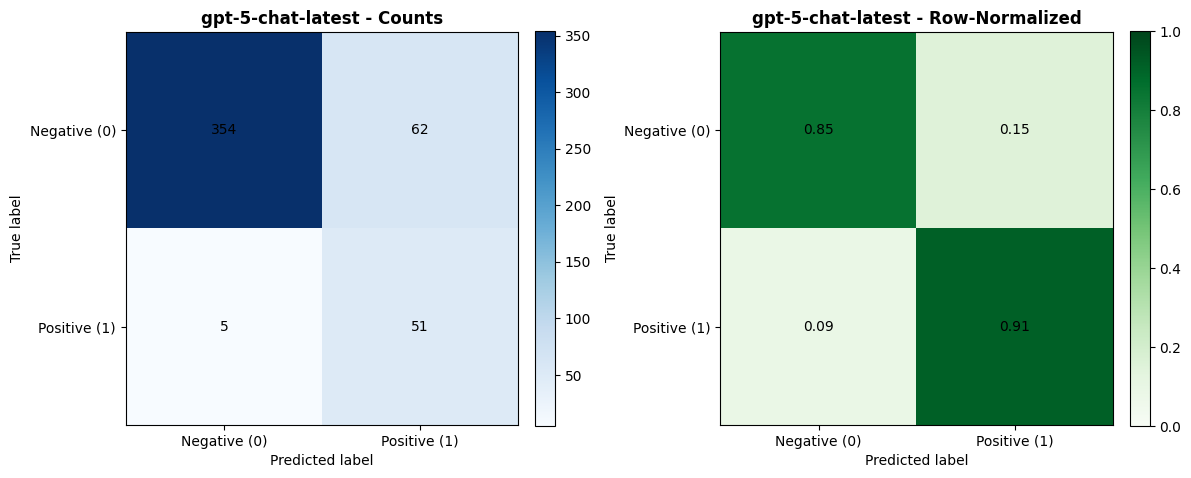

Saved confusion matrix plots to: reports/plots/confusion_matrix_gpt-5-chat-latest.png


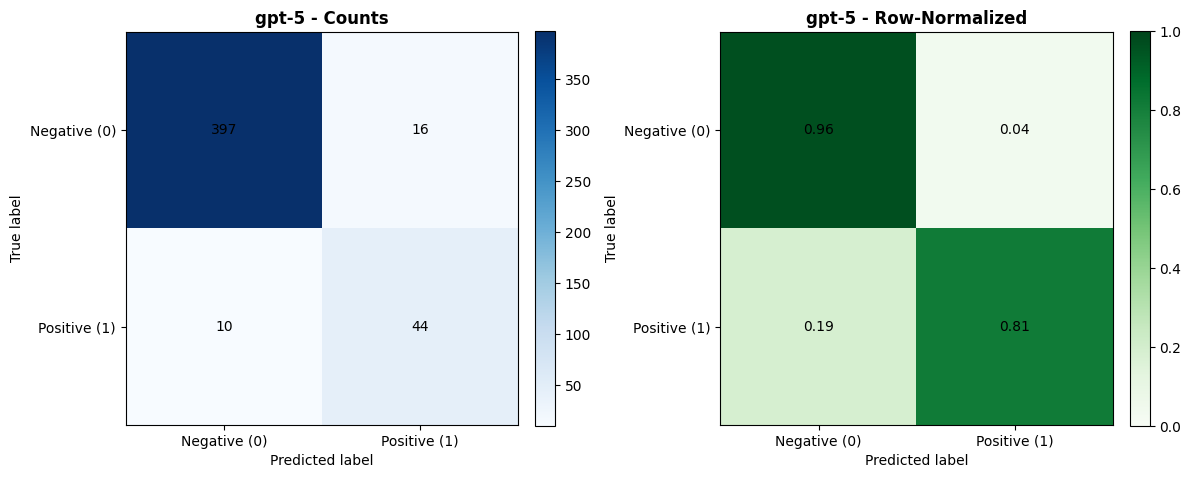

Saved confusion matrix plots to: reports/plots/confusion_matrix_gpt-5.png


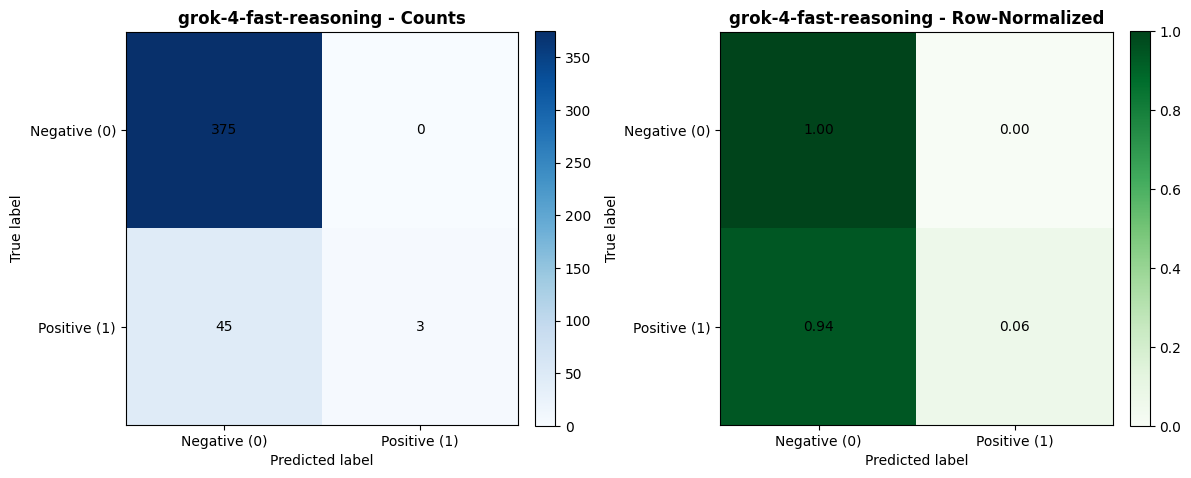

Saved confusion matrix plots to: reports/plots/confusion_matrix_grok-4-fast-reasoning.png


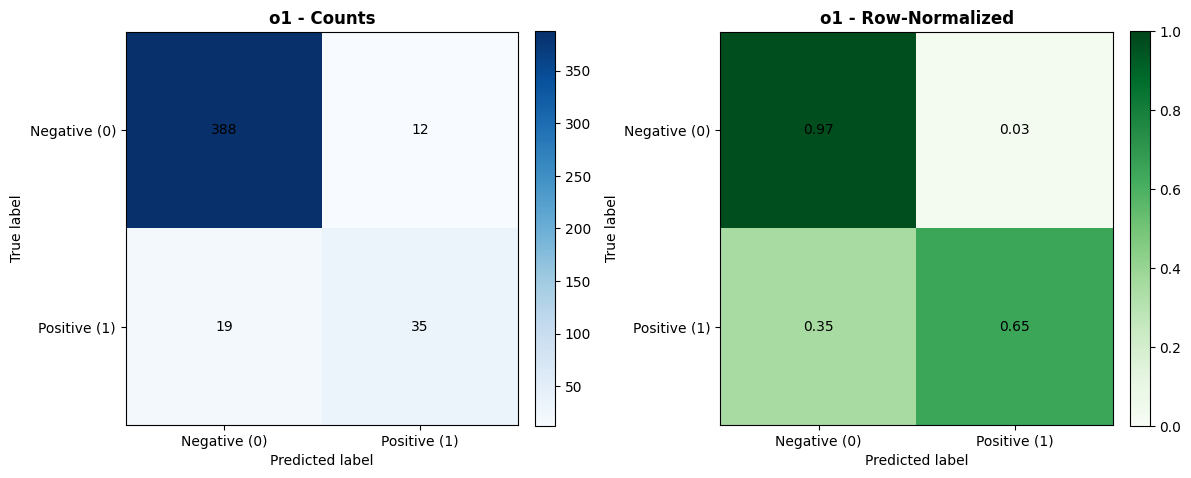

Saved confusion matrix plots to: reports/plots/confusion_matrix_o1.png


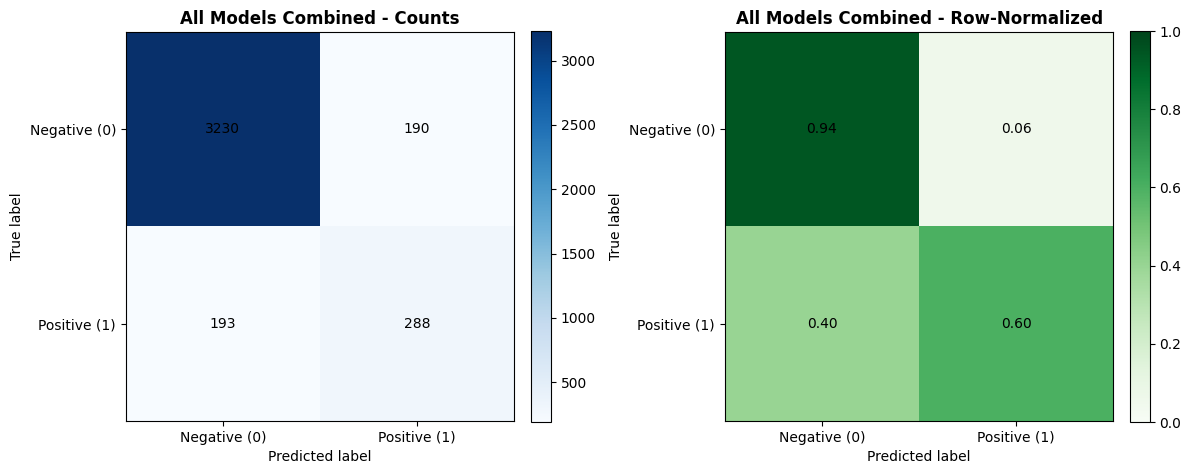

Saved confusion matrix plots to: reports/plots/confusion_matrix_all_models.png


In [46]:
# Plot and save confusion matrix heatmaps per model and overall (matplotlib only)
print("=== Creating Confusion Matrix Plots (matplotlib) ===")

# Helper to plot a single confusion matrix (counts and normalized) using matplotlib only
def plot_confusion_matrices(cm_counts, title_prefix, save_basename):
    labels = ['Negative (0)', 'Positive (1)']

    # Normalized by true label counts (row-wise)
    with np.errstate(invalid='ignore', divide='ignore'):
        row_sums = cm_counts.sum(axis=1, keepdims=True)
        cm_norm = np.divide(cm_counts, row_sums, out=np.zeros_like(cm_counts, dtype=float), where=row_sums!=0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Counts heatmap
    im0 = axes[0].imshow(cm_counts, cmap='Blues')
    axes[0].set_title(f"{title_prefix} - Counts", fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Predicted label')
    axes[0].set_ylabel('True label')
    axes[0].set_xticks([0, 1])
    axes[0].set_yticks([0, 1])
    axes[0].set_xticklabels(labels)
    axes[0].set_yticklabels(labels)
    # Annotate counts
    for i in range(cm_counts.shape[0]):
        for j in range(cm_counts.shape[1]):
            axes[0].text(j, i, f"{cm_counts[i, j]}", ha='center', va='center', color='black', fontsize=10)
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # Normalized heatmap
    im1 = axes[1].imshow(cm_norm, cmap='Greens', vmin=0, vmax=1)
    axes[1].set_title(f"{title_prefix} - Row-Normalized", fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Predicted label')
    axes[1].set_ylabel('True label')
    axes[1].set_xticks([0, 1])
    axes[1].set_yticks([0, 1])
    axes[1].set_xticklabels(labels)
    axes[1].set_yticklabels(labels)
    # Annotate normalized values
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            axes[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.savefig(f"reports/plots/{save_basename}.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved confusion matrix plots to: reports/plots/{save_basename}.png")

# Per-model confusion matrices (use only rows where both y_true and y_pred are available)
for model_name, model_df in model_dataframes.items():
    # Ensure ground truth is present
    if 'ground_truth' not in model_df.columns:
        model_df['ground_truth'] = model_df['experiment_id'].astype(int).map(experiment_to_ground_truth)

    valid = model_df['ground_truth'].notna() & model_df['midline_shift_prediction'].notna()
    valid_df = model_df[valid].copy()

    if len(valid_df) == 0:
        print(f"Skipping {model_name}: no valid pairs of y_true and y_pred")
        continue

    y_true = valid_df['ground_truth'].astype(int)
    y_pred = valid_df['midline_shift_prediction'].astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    safe_model_name = str(model_name).replace('/', '-').replace(' ', '_')
    plot_confusion_matrices(cm, f"{model_name}", f"confusion_matrix_{safe_model_name}")

# Overall confusion matrix across all models
overall_df = df[df['ground_truth'].notna() & df['midline_shift_prediction'].notna()].copy()
if len(overall_df) > 0:
    y_true_all = overall_df['ground_truth'].astype(int)
    y_pred_all = overall_df['midline_shift_prediction'].astype(int)
    cm_all = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])
    plot_confusion_matrices(cm_all, 'All Models Combined', 'confusion_matrix_all_models')
else:
    print('No overall pairs of y_true and y_pred available for confusion matrix.')

In [47]:
# Save accuracy metrics data to CSV
metrics_df.to_csv('reports/csv_reports/model_accuracy_metrics.csv')
print("Saved accuracy metrics data to: reports/csv_reports/model_accuracy_metrics.csv")

Saved accuracy metrics data to: reports/csv_reports/model_accuracy_metrics.csv


# Cost Analysis

In [13]:
# Define pricing per 1M tokens based on the provided cost information
pricing_data = {
    'gpt-4o': {'input': 2.5, 'output': 10.00},
    'gpt-4.1': {'input': 2.00, 'output': 8.00},
    'gpt-5': {'input': 1.25, 'output': 10.00},
    'gpt-5-chat-latest': {'input': 1.25, 'output': 10.00},
    'o1': {'input': 15.00, 'output': 60.00},
    'claude-opus-4-20250514': {'input': 15.00, 'output': 75.00},
    'claude-opus-4-1-20250805': {'input': 15.00, 'output': 75.00},
    'claude-sonnet-4-20250514': {'input': 3.00, 'output': 15.00},
    'claude-3-7-sonnet-latest': {'input': 3.00, 'output': 15.00},
    'grok-4-fast-reasoning': {'input': 0.2, 'output': 0.5}
}

In [14]:
# Cost Analysis - Token Usage and Pricing
print("=== Cost Analysis: Token Usage and Pricing ===")

# Calculate average input tokens per request for each model
print("\n=== Average Input Tokens per Request ===")
input_token_analysis = {}

for model_name, model_df in model_dataframes.items():
    if model_name in pricing_data:
        avg_input_tokens = model_df['input_tokens'].mean()
        input_token_analysis[model_name] = {
            'avg_input_tokens': avg_input_tokens,
            'std_input_tokens': model_df['input_tokens'].std(),
            'min_input_tokens': model_df['input_tokens'].min(),
            'max_input_tokens': model_df['input_tokens'].max(),
            'total_requests': len(model_df)
        }
        
        print(f"{model_name}:")
        print(f"  Average input tokens: {avg_input_tokens:.2f}")
        print(f"  Std deviation: {model_df['input_tokens'].std():.2f}")
        print(f"  Range: {model_df['input_tokens'].min():.0f} - {model_df['input_tokens'].max():.0f}")
        print(f"  Total requests: {len(model_df)}")
        print()

# Convert to DataFrame for easier analysis
input_token_df = pd.DataFrame(input_token_analysis).T

=== Cost Analysis: Token Usage and Pricing ===

=== Average Input Tokens per Request ===
claude-3-7-sonnet-latest:
  Average input tokens: 486.00
  Std deviation: 0.00
  Range: 486 - 486
  Total requests: 472

claude-opus-4-1-20250805:
  Average input tokens: 486.00
  Std deviation: 0.00
  Range: 486 - 486
  Total requests: 472

claude-opus-4-20250514:
  Average input tokens: 486.00
  Std deviation: 0.00
  Range: 486 - 486
  Total requests: 472

claude-sonnet-4-20250514:
  Average input tokens: 486.00
  Std deviation: 0.00
  Range: 486 - 486
  Total requests: 472

gpt-4.1:
  Average input tokens: 432.00
  Std deviation: 0.00
  Range: 432 - 432
  Total requests: 472

gpt-4o:
  Average input tokens: 432.00
  Std deviation: 0.00
  Range: 432 - 432
  Total requests: 472

gpt-5-chat-latest:
  Average input tokens: 402.00
  Std deviation: 0.00
  Range: 402 - 402
  Total requests: 472

gpt-5:
  Average input tokens: 382.00
  Std deviation: 0.00
  Range: 382 - 382
  Total requests: 472

grok-4

In [15]:
# Calculate average output tokens per request for each model
print("\n=== Average Output Tokens per Request ===")
output_token_analysis = {}

for model_name, model_df in model_dataframes.items():
    if model_name in pricing_data:
        avg_output_tokens = model_df['output_tokens'].mean()
        output_token_analysis[model_name] = {
            'avg_output_tokens': avg_output_tokens,
            'std_output_tokens': model_df['output_tokens'].std(),
            'min_output_tokens': model_df['output_tokens'].min(),
            'max_output_tokens': model_df['output_tokens'].max(),
            'total_requests': len(model_df)
        }
        
        print(f"{model_name}:")
        print(f"  Average output tokens: {avg_output_tokens:.2f}")
        print(f"  Std deviation: {model_df['output_tokens'].std():.2f}")
        print(f"  Range: {model_df['output_tokens'].min():.0f} - {model_df['output_tokens'].max():.0f}")
        print(f"  Total requests: {len(model_df)}")
        print()

# Convert to DataFrame for easier analysis
output_token_df = pd.DataFrame(output_token_analysis).T


=== Average Output Tokens per Request ===
claude-3-7-sonnet-latest:
  Average output tokens: 14.03
  Std deviation: 0.47
  Range: 14 - 23
  Total requests: 472

claude-opus-4-1-20250805:
  Average output tokens: 25.20
  Std deviation: 27.38
  Range: 14 - 133
  Total requests: 472

claude-opus-4-20250514:
  Average output tokens: 19.40
  Std deviation: 19.28
  Range: 14 - 113
  Total requests: 472

claude-sonnet-4-20250514:
  Average output tokens: 16.01
  Std deviation: 10.30
  Range: 14 - 87
  Total requests: 472

gpt-4.1:
  Average output tokens: 116.70
  Std deviation: 886.78
  Range: 11 - 14415
  Total requests: 472

gpt-4o:
  Average output tokens: 409.81
  Std deviation: 2002.99
  Range: 9 - 16384
  Total requests: 472

gpt-5-chat-latest:
  Average output tokens: 9.01
  Std deviation: 0.15
  Range: 9 - 12
  Total requests: 472

gpt-5:
  Average output tokens: 769.45
  Std deviation: 1171.42
  Range: 90 - 19059
  Total requests: 472

grok-4-fast-reasoning:
  Average output tokens

In [16]:
# Calculate average cost per request for each model
print("\n=== Average Cost per Request ===")
cost_analysis = {}

for model_name, model_df in model_dataframes.items():
    if model_name in pricing_data:
        # Get pricing for this model
        input_price_per_1m = pricing_data[model_name]['input']
        output_price_per_1m = pricing_data[model_name]['output']
        
        # Calculate costs for each request
        input_costs = (model_df['input_tokens'] / 1_000_000) * input_price_per_1m
        output_costs = (model_df['output_tokens'] / 1_000_000) * output_price_per_1m
        total_costs = input_costs + output_costs
        
        # Calculate averages
        avg_input_cost = input_costs.mean()
        avg_output_cost = output_costs.mean()
        avg_total_cost = total_costs.mean()
        
        cost_analysis[model_name] = {
            'avg_input_cost': avg_input_cost,
            'avg_output_cost': avg_output_cost,
            'avg_total_cost': avg_total_cost,
            'input_price_per_1m': input_price_per_1m,
            'output_price_per_1m': output_price_per_1m,
            'total_requests': len(model_df)
        }
        
        print(f"{model_name}:")
        print(f"  Input cost per 1M tokens: ${input_price_per_1m:.2f}")
        print(f"  Output cost per 1M tokens: ${output_price_per_1m:.2f}")
        print(f"  Average input cost per request: ${avg_input_cost:.6f}")
        print(f"  Average output cost per request: ${avg_output_cost:.6f}")
        print(f"  Average total cost per request: ${avg_total_cost:.6f}")
        print(f"  Total requests: {len(model_df)}")
        print()

# Convert to DataFrame for easier analysis
cost_df = pd.DataFrame(cost_analysis).T


=== Average Cost per Request ===
claude-3-7-sonnet-latest:
  Input cost per 1M tokens: $3.00
  Output cost per 1M tokens: $15.00
  Average input cost per request: $0.001458
  Average output cost per request: $0.000210
  Average total cost per request: $0.001668
  Total requests: 472

claude-opus-4-1-20250805:
  Input cost per 1M tokens: $15.00
  Output cost per 1M tokens: $75.00
  Average input cost per request: $0.007290
  Average output cost per request: $0.001890
  Average total cost per request: $0.009180
  Total requests: 472

claude-opus-4-20250514:
  Input cost per 1M tokens: $15.00
  Output cost per 1M tokens: $75.00
  Average input cost per request: $0.007290
  Average output cost per request: $0.001455
  Average total cost per request: $0.008745
  Total requests: 472

claude-sonnet-4-20250514:
  Input cost per 1M tokens: $3.00
  Output cost per 1M tokens: $15.00
  Average input cost per request: $0.001458
  Average output cost per request: $0.000240
  Average total cost per 

In [17]:
# Create scatter plots for cost vs accuracy and tokens vs accuracy
print("=== Creating Scatter Plots: Cost vs Accuracy and Tokens vs Accuracy ===")

# Combine all metrics into a single dataframe for scatter plots
scatter_data = []

for model_name in metrics_df.index:
    if model_name in cost_df.index:
        # Get accuracy
        accuracy = metrics_df.loc[model_name, 'accuracy']
        
        # Get cost data
        avg_total_cost = cost_df.loc[model_name, 'avg_total_cost']
        
        # Get token data
        avg_input_tokens = input_token_df.loc[model_name, 'avg_input_tokens']
        avg_output_tokens = output_token_df.loc[model_name, 'avg_output_tokens']
        avg_total_tokens = avg_input_tokens + avg_output_tokens
        
        scatter_data.append({
            'model_name': model_name,
            'accuracy': accuracy,
            'avg_total_cost': avg_total_cost,
            'avg_input_tokens': avg_input_tokens,
            'avg_output_tokens': avg_output_tokens,
            'avg_total_tokens': avg_total_tokens
        })

# Convert to DataFrame
scatter_df = pd.DataFrame(scatter_data)

=== Creating Scatter Plots: Cost vs Accuracy and Tokens vs Accuracy ===


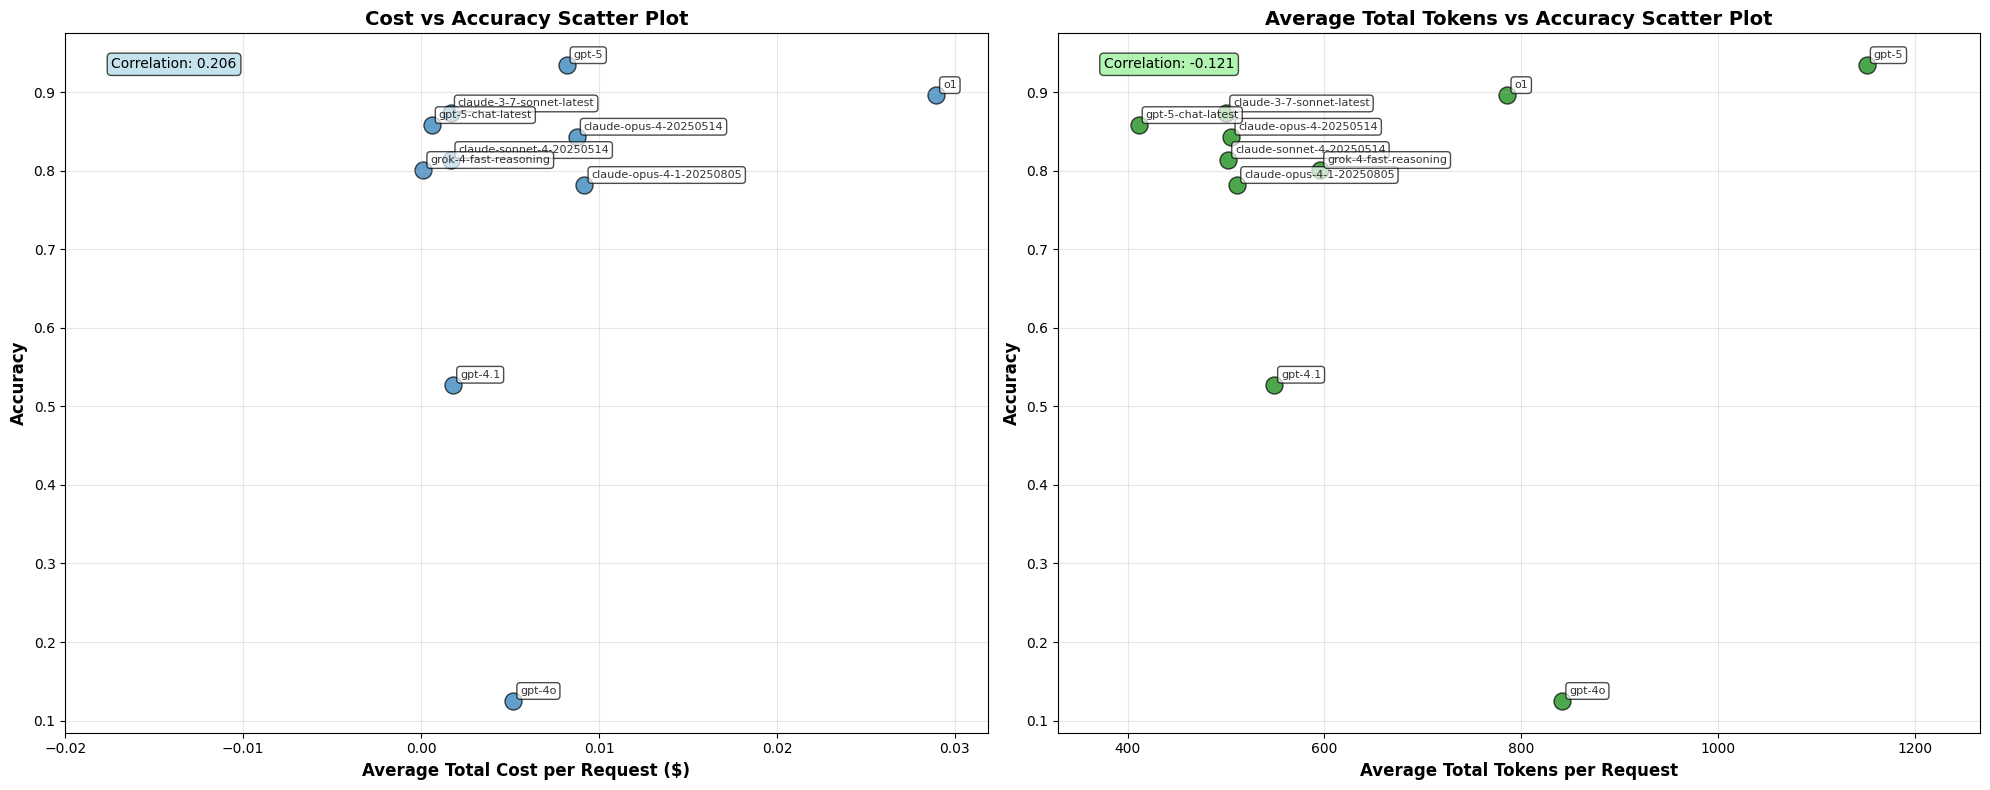

Saved scatter plots to: reports/plots/cost_tokens_vs_accuracy_scatter.png
Cost vs Accuracy correlation: 0.206
Tokens vs Accuracy correlation: -0.121


In [18]:
# Create scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Cost vs Accuracy
ax1.scatter(scatter_df['avg_total_cost'], scatter_df['accuracy'], 
           s=150, alpha=0.7, edgecolors='black', linewidth=1)

# Add model labels
for i, model in enumerate(scatter_df['model_name']):
    ax1.annotate(model, 
                (scatter_df['avg_total_cost'].iloc[i], scatter_df['accuracy'].iloc[i]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax1.set_xlabel('Average Total Cost per Request ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Cost vs Accuracy Scatter Plot', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-0.02, scatter_df['avg_total_cost'].max() * 1.1])

# Add correlation coefficient
correlation_cost = scatter_df['avg_total_cost'].corr(scatter_df['accuracy'])
ax1.text(0.05, 0.95, f'Correlation: {correlation_cost:.3f}', 
         transform=ax1.transAxes, fontsize=10, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

# Plot 2: Average Total Tokens vs Accuracy
ax2.scatter(scatter_df['avg_total_tokens'], scatter_df['accuracy'], 
           s=150, alpha=0.7, edgecolors='black', linewidth=1, color='green')

# Add model labels
for i, model in enumerate(scatter_df['model_name']):
    ax2.annotate(model, 
                (scatter_df['avg_total_tokens'].iloc[i], scatter_df['accuracy'].iloc[i]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax2.set_xlabel('Average Total Tokens per Request', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Average Total Tokens vs Accuracy Scatter Plot', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([scatter_df['avg_total_tokens'].min() * 0.8, scatter_df['avg_total_tokens'].max() * 1.1])

# Add correlation coefficient
correlation_tokens = scatter_df['avg_total_tokens'].corr(scatter_df['accuracy'])
ax2.text(0.05, 0.95, f'Correlation: {correlation_tokens:.3f}', 
         transform=ax2.transAxes, fontsize=10, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.savefig('reports/plots/cost_tokens_vs_accuracy_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved scatter plots to: reports/plots/cost_tokens_vs_accuracy_scatter.png")
print(f"Cost vs Accuracy correlation: {correlation_cost:.3f}")
print(f"Tokens vs Accuracy correlation: {correlation_tokens:.3f}")